Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_1  │ (None, 200, 32)        │       646,400 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ (None, 200, 32)        │        10,656 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 20)             │           660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            42 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 657,758 (2.51 MB)

 Trainable params: 657,758 (2.51 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
782/782 ━━━━━━━━━━━━━━━━━━━━ 109s 132ms/step - accuracy: 0.6982 - loss: 0.5252 - val_accuracy: 0.8665 - val_loss: 0.3035
Epoch 2/2
782/782 ━━━━━━━━━━━━━━━━━━━━ 118s 151ms/step - accuracy: 0.9250 - loss: 0.2046 - val_accuracy: 0.8720 - val_loss: 0.3084

Training and Validation Results:
Epoch 1: Train Loss=0.4002, Train Acc=0.8040, Val Loss=0.3035, Val Acc=0.8665
Epoch 2: Train Loss=0.1995, Train Acc=0.9240, Val Loss=0.3084, Val Acc=0.8720


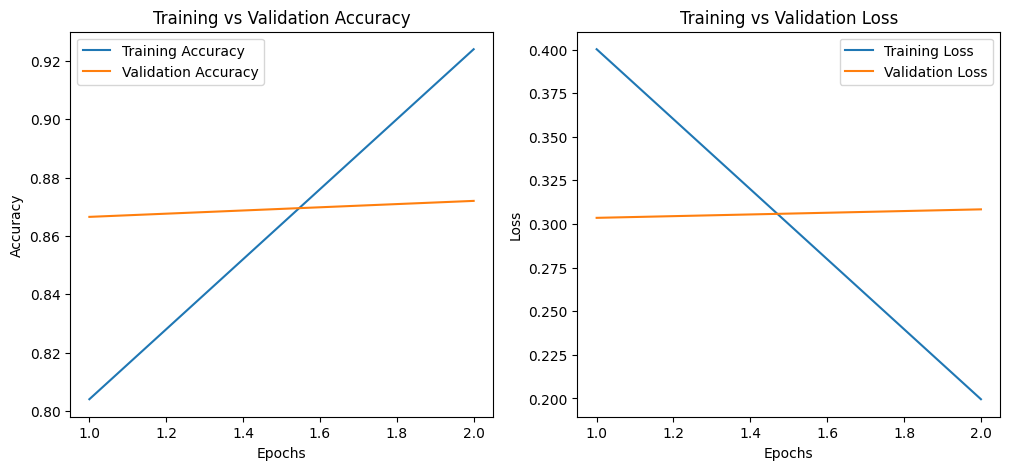

In [3]:
"""
Homework 11: Transformer Model for Binary Sentiment Classification
---------------------------------------------------------------

1️⃣ Define Transformer Layer (custom class)
2️⃣ Define Token+Position Embedding Layer (custom class)
3️⃣ Build the Classifier model
4️⃣ Prepare IMDB dataset (top 20,000 words, maxlen=200)
5️⃣ Train for 2 epochs, batch_size=32, using Adam optimizer
6️⃣ Display training/validation accuracy and loss for each epoch
"""

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

# ------------------------------------------------------------
# 1️⃣ Define Transformer Block (Custom Layer)
# ------------------------------------------------------------
class TransformerBlock(layers.Layer):
    """
    Custom Transformer block with:
    - Multi-head self-attention
    - Feed-forward sublayer
    - Residual connections + Layer Normalization
    """
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        # Multi-head self-attention
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        # Feed-forward network (two dense layers)
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        # Normalization and dropout layers
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=None):
        # Self-attention sublayer
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)  # Residual connection

        # Feed-forward sublayer
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        # Second residual connection
        return self.layernorm2(out1 + ffn_output)

# ------------------------------------------------------------
# 2️⃣ Define Token + Position Embedding Layer
# ------------------------------------------------------------
class TokenAndPositionEmbedding(layers.Layer):
    """
    Custom Embedding layer that adds:
    - Token embeddings (word representations)
    - Positional embeddings (position in sequence)
    """
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        # Generate positional indices [0, 1, 2, ..., maxlen-1]
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions  # Combine token + position embeddings

# ------------------------------------------------------------
# 3️⃣ Load and Prepare IMDB Dataset
# ------------------------------------------------------------
vocab_size = 20000  # Top 20,000 frequent words
maxlen = 200        # Input sequence length

# Load IMDB dataset (Keras built-in)
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(num_words=vocab_size)

# Pad or truncate all sequences to the same length
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)

# ------------------------------------------------------------
# 4️⃣ Build the Transformer-based Classifier Model
# ------------------------------------------------------------
embed_dim = 32  # Embedding dimension
num_heads = 2   # Number of attention heads
ff_dim = 32     # Feed-forward network dimension

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)

# Add one Transformer block as required
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)

# Apply global average pooling
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)  # Output layer (binary classification)

# Create and compile the model
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Display model structure
model.summary()

# ------------------------------------------------------------
# 5️⃣ Train the Model
# ------------------------------------------------------------
history = model.fit(
    x_train, y_train,
    batch_size=32,
    epochs=2,  # As per homework instructions
    validation_data=(x_val, y_val)
)

# ------------------------------------------------------------
# 6️⃣ Display Accuracy and Loss per Epoch
# ------------------------------------------------------------
print("\nTraining and Validation Results:")
for i in range(len(history.history["loss"])):
    print(f"Epoch {i+1}: "
          f"Train Loss={history.history['loss'][i]:.4f}, "
          f"Train Acc={history.history['accuracy'][i]:.4f}, "
          f"Val Loss={history.history['val_loss'][i]:.4f}, "
          f"Val Acc={history.history['val_accuracy'][i]:.4f}")

# ------------------------------------------------------------
# 7️⃣ Optional: Plot Accuracy and Loss Curves (for visualization)
# ------------------------------------------------------------
import matplotlib.pyplot as plt

epochs_range = range(1, len(history.history["accuracy"]) + 1)

plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history["accuracy"], label="Training Accuracy")
plt.plot(epochs_range, history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history["loss"], label="Training Loss")
plt.plot(epochs_range, history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

plt.show()
